In [1]:
import pandas as pd
import numpy as np
from patsy import dmatrices
from matplotlib.pyplot import matplotlib
from matplotlib.pyplot import *
from statsmodels.graphics.mosaicplot import mosaic
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
%pylab inline
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


C:\Users\judge\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning:

pylab import has clobbered these variables: ['draw_if_interactive']
`%matplotlib` prevents importing * from pylab and numpy



# Feature Engineering

In [2]:
df = pd.read_csv("train.csv",dtype = unicode)
print df.shape
df["v18q1"] = df["v18q1"].fillna(0)
df["rez_esc"] = df["rez_esc"].fillna(0)
def transfer_no(string):
    return 0
df.loc[df["edjefe"] == "no","edjefe"] = 0
df.loc[df["edjefa"] == "no","edjefa"] = 0
df.loc[df["edjefe"] == "yes","edjefe"] = 1
df.loc[df["edjefa"] == "yes","edjefa"] = 1
for col in df.columns.difference(['Id','idhogar',"dependency"]).values:
    df[col] = df[col].astype(float)
df = df.fillna(0)

(9557, 143)


In [3]:
physical_attr=['epared1', 'epared2', 'epared3','etecho1', 'etecho2', 'etecho3','eviv1', 'eviv1', 'eviv1']

In [4]:
# Overall quality of the house 
df['walls'] = np.argmax(np.array(df[['epared1', 'epared2', 'epared3']]),axis = 1)
df['roof']= np.argmax(np.array(df[['etecho1', 'etecho2', 'etecho3']]),axis = 1)
df['floor']= np.argmax(np.array(df[['eviv1', 'eviv2', 'eviv3']]),axis = 1)
df['overall_quality']=df['walls']+df['roof']+df['floor']
df=df.drop(columns=physical_attr)

In [5]:
# Basic_necessities flag - covering the houses with no flooring, ceiling, water provision, electricity, 
df['missing_basic_nec'] =1* (df['pisonotiene']==0) + \
                         (df['cielorazo'] == 0) + \
                         (df['abastaguano'] ==0)+ \
                         (df['noelec'] == 1)+ (df['sanitario1'] == 1) +(df['energcocinar1'] == 1)
#df[df['basic_necessities']==5][['pisonotiene','cielorazo','abastaguano','noelec','sanitario1','energcocinar1']]

In [6]:
df['Area'] = df['area1'].apply(lambda x: "urban" if x==1 else "rural")
#just for clarity 
df.loc[df["tipovivi2"] == 1,"House_Type"] = "own and fully paid house"
df.loc[df["tipovivi1"] == 1,"House_Type"] = "own,  paying in installments"
df.loc[df["tipovivi3"] == 1,"House_Type"] = "rented"
df.loc[df["tipovivi4"] == 1,"House_Type"] = "precarious"
df.loc[df["tipovivi5"] == 1,"House_Type"] = "assigned/borrowed"
df.loc[df["lugar1"] == 1,"Region"] = "Central"
df.loc[df["lugar2"] == 1,"Region"] = "Chorotega"
df.loc[df["lugar3"] == 1,"Region"] = "Pacafafico central"
df.loc[df["lugar4"] == 1,"Region"] = "Brunca"
df.loc[df["lugar5"] == 1,"Region"] = "Huetar Atlafantica"
df.loc[df["lugar6"] == 1,"Region"] = "HuetarNorte"
df.loc[df["parentesco1"] == 1,"Person_Type"] = "household head"
df.loc[df["parentesco2"] == 1,"Person_Type"] = "spouse/partner"
df.loc[df["parentesco3"] == 1,"Person_Type"] = "son/daughter"
df.loc[df["parentesco4"] == 1,"Person_Type"] = "stepson/daughter"
df.loc[df["parentesco5"] == 1,"Person_Type"] = "son/daughter in law"
df.loc[df["parentesco6"] == 1,"Person_Type"] = "grandson/daughter"
df.loc[df["parentesco7"] == 1,"Person_Type"] = "mother/father"
df.loc[df["parentesco8"] == 1,"Person_Type"] = "father/mother in law"
df.loc[df["parentesco9"] == 1,"Person_Type"] = "brother/sister"
df.loc[df["parentesco10"] == 1,"Person_Type"] = "brother/sister in law"
df.loc[df["parentesco11"] == 1,"Person_Type"] = "other family member"
df.loc[df["parentesco12"] == 1,"Person_Type"] = "other non family member"

In [7]:
df.columns.values

array(['Id', 'v2a1', 'hacdor', 'rooms', 'hacapo', 'v14a', 'refrig',
       'v18q', 'v18q1', 'r4h1', 'r4h2', 'r4h3', 'r4m1', 'r4m2', 'r4m3',
       'r4t1', 'r4t2', 'r4t3', 'tamhog', 'tamviv', 'escolari', 'rez_esc',
       'hhsize', 'paredblolad', 'paredzocalo', 'paredpreb', 'pareddes',
       'paredmad', 'paredzinc', 'paredfibras', 'paredother', 'pisomoscer',
       'pisocemento', 'pisoother', 'pisonatur', 'pisonotiene',
       'pisomadera', 'techozinc', 'techoentrepiso', 'techocane',
       'techootro', 'cielorazo', 'abastaguadentro', 'abastaguafuera',
       'abastaguano', 'public', 'planpri', 'noelec', 'coopele',
       'sanitario1', 'sanitario2', 'sanitario3', 'sanitario5',
       'sanitario6', 'energcocinar1', 'energcocinar2', 'energcocinar3',
       'energcocinar4', 'elimbasu1', 'elimbasu2', 'elimbasu3',
       'elimbasu4', 'elimbasu5', 'elimbasu6', 'eviv2', 'eviv3', 'dis',
       'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3',
       'estadocivil4', 'estadocivil

In [8]:
#In this script, we'll be applying more complex models. So, the squared features are redundant and are highly correlated 
# with the original attributes. Hence, eliminating these variables 
df=df.drop(columns=['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq'])

In [9]:
#df=df.drop(columns=['tipovivi1', 'tipovivi2','tipovivi3', 'tipovivi4', 'tipovivi5','lugar1', 'lugar2', 'lugar3','lugar4', 'lugar5', 'lugar6','parentesco1', 'parentesco2', 'parentesco3',
#                    'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7','parentesco8', 'parentesco9', 'parentesco10', 'parentesco11','parentesco12','area1','area2'])

In [10]:
df.shape

(9557, 136)

In [11]:
df = df.drop(columns = ["Id","dependency"])

In [12]:
# Summarising the attributes on a household level
age = df.groupby(["idhogar"])[["age"]].mean()
school = df.groupby(["idhogar"])[["escolari"]].mean()
behind_school = df.groupby(["idhogar"])[["rez_esc"]].mean()
qmobile = df.groupby(["idhogar"])[["qmobilephone"]].mean()
education = df.groupby(["idhogar"])\
["instlevel1","instlevel2","instlevel3","instlevel4","instlevel5","instlevel6","instlevel7","instlevel8","instlevel9"].sum()
new_df=df[df['Person_Type'] ==  "household head"]
new_df = df.drop_duplicates(["idhogar"])
new_df.shape
new_df = new_df.set_index(["idhogar"])
#Removing individual level columns 
new_df = new_df.drop(columns=['instlevel1','v18q',\
       'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5',\
       'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9',\
       'dis', 'male', 'female', 'estadocivil1', 'estadocivil2',\
       'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6',\
       'estadocivil7','r4h3','r4m3','r4t1',"age",
       'r4t2', 'r4t3','qmobilephone',"rez_esc",'Person_Type'])
#'Labor' = # of independent people (Size of household-(<19yrs old + >65+ yrs old))
new_df["Labor"] = (new_df["hogar_total"] - new_df["hogar_mayor"] - new_df["hogar_nin"])
new_df["supportRate"] = new_df["Labor"]/(new_df["hogar_total"])
# Joining the summairsed attributes with already existing household level attributes 
df_family = new_df.merge(age, left_index=True, right_index=True).\
    merge(behind_school, left_index=True, right_index=True).\
    merge(qmobile, left_index=True, right_index=True).\
    merge(education, left_index=True, right_index=True)

In [13]:
df_family.shape

(2988, 118)

In [14]:
# Further dimenionality reduction based on the correlation matrix 
corr_matrix = df_family.corr()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

Even before running the correlation matrix, the below four columns convey the same information

tamhog, size of the household

tamviv, number of persons living in the household

hhsize, household size

hogar_total, # of total individuals in the household

Let's see if this shows up in the correaltion matrix

In [15]:
# Dropping columns with correlation>0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]
to_drop

['hhsize', 'coopele', 'hogar_total', 'area2']

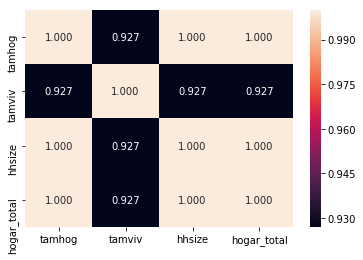

In [16]:
sns.heatmap(corr_matrix.loc[corr_matrix['tamhog'].abs() > 0.9, corr_matrix['tamhog'].abs() > 0.9],
            annot=True, fmt='.3f')
#tamviv is different because number of people living has different meaning than the absolute size of the household i.e. why it 
# has a slightly less correlation while others as expected ha perfect correlation of 1. Hnece, must be dropped 

In [17]:
# coopele- 'electricity from cooperative' 
corr_matrix.loc[corr_matrix['coopele'].abs() > 0.9, corr_matrix['coopele'].abs() > 0.9]

,public,coopele
public,1.000,-0.975
coopele,-0.975,1.000


public, "=1 electricity from CNFL,  ICE,  ESPH/JASEC" ;    
planpri, =1 electricity from private plant;  
noelec, =1 no electricity in the dwelling;   
coopele, =1 electricity from cooperative; 

In [18]:
df_family.loc[df_family["public"] == 1,"electricity_Type"] = "public"
df_family.loc[df_family["planpri"] == 1,"electricity_Type"] = "planpri"
df_family.loc[df_family["noelec"] == 1,"electricity_Type"] = "noelec"
df_family.loc[df_family["coopele"] == 1,"electricity_Type"] = "coopele"

In [19]:
df_family=df_family.drop(columns = ["public", "planpri", "noelec","coopele",'hhsize','hogar_total'])

In [20]:
df_family.shape

(2988, 113)

In [21]:
df_family.columns.values

array(['v2a1', 'hacdor', 'rooms', 'hacapo', 'v14a', 'refrig', 'v18q1',
       'r4h1', 'r4h2', 'r4m1', 'r4m2', 'tamhog', 'tamviv', 'escolari',
       'paredblolad', 'paredzocalo', 'paredpreb', 'pareddes', 'paredmad',
       'paredzinc', 'paredfibras', 'paredother', 'pisomoscer',
       'pisocemento', 'pisoother', 'pisonatur', 'pisonotiene',
       'pisomadera', 'techozinc', 'techoentrepiso', 'techocane',
       'techootro', 'cielorazo', 'abastaguadentro', 'abastaguafuera',
       'abastaguano', 'sanitario1', 'sanitario2', 'sanitario3',
       'sanitario5', 'sanitario6', 'energcocinar1', 'energcocinar2',
       'energcocinar3', 'energcocinar4', 'elimbasu1', 'elimbasu2',
       'elimbasu3', 'elimbasu4', 'elimbasu5', 'elimbasu6', 'eviv2',
       'eviv3', 'parentesco1', 'parentesco2', 'parentesco3',
       'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7',
       'parentesco8', 'parentesco9', 'parentesco10', 'parentesco11',
       'parentesco12', 'hogar_nin', 'hogar_adul', 'hogar_m

In [22]:
df_type=pd.DataFrame(df_family.dtypes)
df_type[df_type[0]!='float64']

,0
walls,int64
roof,int64
floor,int64
overall_quality,int64
missing_basic_nec,int32
Area,object
House_Type,object
Region,object
electricity_Type,object


# Modelling

In [23]:
# Imputing the missing values and scaling the attributes values for comparision between models 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
pipeline = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='median')), 
                      ('scaler', MinMaxScaler())])


In [24]:
train_X = pipeline.fit_transform(df_family.drop(columns=['Target','Area','House_Type','Region','electricity_Type']))

In [25]:
features=df_family.drop(columns=['Target','Area','House_Type','Region','electricity_Type']).columns

In [26]:
train_Y=np.array(list(df_family['Target'])).astype(int)

Reason to choose F1_score 

For imbalanced datasets, F1-score (a weighted average of precision and recall) stands as a better measure of classifier quality.

In [27]:
from sklearn.metrics import f1_score, make_scorer, accuracy_score
scorer = make_scorer(f1_score, greater_is_better=True, average = 'macro')
scoring = {'accuracy': make_scorer(accuracy_score),'f1_score':make_scorer(f1_score, greater_is_better=True, average = 'macro')}

In [28]:
scoring

{'accuracy': make_scorer(accuracy_score),
 'f1_score': make_scorer(f1_score, average=macro)}

In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
model_output=pd.DataFrame()
model_output=pd.DataFrame(columns=['Model','F1score','F1score_std','Accuracy','Accuracy_std'])
def output(train_X,train_Y,model,model_name,model_output=None):
    #cvscores = cross_val_score(model, train_X, train_Y, cv = 10, scoring=scorer, n_jobs = -1)
    cvscores = cross_validate(model, train_X, train_Y, cv = 10, scoring=scoring, n_jobs = -1)
    #print cvscores['test_accuracy'].mean()
    #print cvscores['test_f1_score'].mean()
    if model_output is not None:
        model_output = model_output.append(pd.DataFrame({'Model': model_name,
                                                           'F1score': cvscores['test_f1_score'].mean(),\
                                                         'F1score_std':cvscores['test_f1_score'].std(),\
                                                            'Accuracy':cvscores['test_accuracy'].mean(),\
                                                        'Accuracy_std':cvscores['test_accuracy'].std()},index = [0]),ignore_index = True)
        return model_output

model_output = output(train_X, train_Y,RandomForestClassifier(100, random_state=10, n_jobs = -1),\
                      'RandomForest', model_output)

model_output

# Trying out different models 

In [31]:
#Random Forest 
from sklearn.ensemble import RandomForestClassifier
model_output = output(train_X, train_Y,RandomForestClassifier(100, random_state=10, n_jobs = -1),\
                      'RandomForest', model_output)

In [33]:
#Support Vector Machines
from sklearn.svm import LinearSVC
model_output = output(train_X, train_Y,LinearSVC(),'LinearSVC', model_output)

In [34]:
#Linear Discriminant Analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
model_output = output(train_X, train_Y,LinearDiscriminantAnalysis(),'LDA', model_output)

In [35]:
#Multi-layer Perceptron
from sklearn.neural_network import MLPClassifier
model_output = output(train_X, train_Y,MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2),random_state=1),\
                      'MLP', model_output)

In [36]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
model_output = output(train_X, train_Y,KNeighborsClassifier(n_neighbors = 10),'KNN-10', model_output)

ExtraTrees classifier always tests random splits over fraction of features (in contrast to RandomForest, which tests all possible splits over fraction of features)

In [37]:
# ExtraTrees Classifier
from sklearn.ensemble import ExtraTreesClassifier
model_output = output(train_X, train_Y,ExtraTreesClassifier(n_estimators = 100),'Extratrees', model_output)

Recursive feature elimination with cross-validated is selection of the best number of features based on the feature importance scores. At each iteration, this method removes either a fraction of features. The iterations continue until the cross validation score no longer improves. The selector in the model lists out the ranking of the features and only the features with rank 1 are retained. 

In [38]:
# Recursive Feature Elimination with Cross Validation - Random Forest
from sklearn.feature_selection import RFECV
RF_estimator=RandomForestClassifier(random_state = 10, n_estimators = 100,  n_jobs = -1)
selector=RFECV(RF_estimator, step =1, cv = 4, scoring= scorer, n_jobs = -1)
selector.fit(train_X, train_Y)
print (selector.n_features_)

16


In [39]:
train_X_df= pd.DataFrame(train_X, columns = features)
selected_features = train_X_df.columns[np.where(selector.ranking_==1)]
train_selected = pd.DataFrame(selector.transform(train_X), columns = selected_features)
model_output = output(train_selected, train_Y, RandomForestClassifier(random_state = 10, n_estimators = 100,  n_jobs = -1),\
                      'RF_RFECV', model_output)

In [40]:
#XGBoost
import xgboost as xgb
model_output = output(train_X, train_Y,xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05),\
                      'XGB', model_output)

Early stopping support in Gradient Boosting enables us to find the least number of iterations which is sufficient to build a model that generalizes well to unseen data. 'validation_fraction' parameter in the below chunk denotes the fraction of the  dataset that will be kept aside from training to assess the validation loss of the model when each additional stage of regression tree is added. This is continued until the scores of the model in the last n_iter_no_change stages do not improve by atleast tol.
Gradient Boosting though might not improve the score, but it provides computational efficiency as you can see the run time difference below. 

In [41]:
# Early stopping of Gradient Boosting 
# We specify that if the scores don't improve by atleast 0.01 for the last
# 10 stages, stop fitting additional stages
from sklearn import ensemble
n_estimators=300
gb = ensemble.GradientBoostingClassifier(n_estimators=n_estimators,
                                             random_state=0)
gb_es = ensemble.GradientBoostingClassifier(n_estimators=n_estimators,
                                               validation_fraction=0.2,
                                               n_iter_no_change=5, tol=0.01,
                                               random_state=0)
start = time.time()
gb.fit(train_X, train_Y)
print "GB-time", (time.time() - start)
start = time.time()
gb_es.fit(train_X,train_Y)
print "GB with early stopping-time", (time.time() - start)
model_output = output(train_X, train_Y,gb,'GB', model_output)
model_output = output(train_X, train_Y,gb,'GB_Earlystopping', model_output)

GB-time 12.2289998531
GB with early stopping-time 1.71500015259


In [42]:
print "Number of stages of the final model with early stopping:",(gb_es.n_estimators_)

Number of stages of the final model with early stopping: 44


In [43]:
model_output

,Accuracy,Accuracy_std,F1score,F1score_std,Model
0,0.653806,0.034859,0.319113,0.044318,RandomForest
1,0.581171,0.119602,0.266380,0.034250,LinearSVC
2,0.568383,0.138894,0.304514,0.060784,LDA
3,0.559268,0.162280,0.247642,0.067310,MLP
4,0.594735,0.064468,0.248609,0.031710,KNN-10
5,0.615517,0.079780,0.278695,0.046255,Extratrees
6,0.663642,0.018748,0.356524,0.041731,RF_RFECV
7,0.599959,0.115732,0.298528,0.068441,XGB
8,0.567304,0.144097,0.304823,0.066827,GB
9,0.567304,0.144097,0.304823,0.066827,GB_Earlystopping


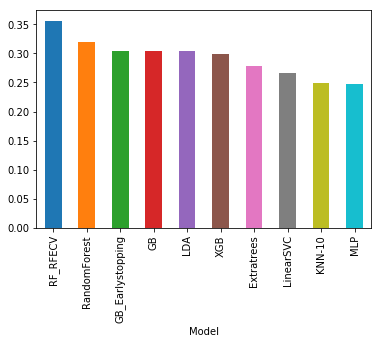

In [51]:
model_output.set_index('Model', inplace = True)
model_output['F1score'].sort_values(ascending=False).plot(kind='bar')

I have considered the default values as hyper parameters for the above models i.e. there was no tuning of paramaters. 
However, using GridSearchCV we can select the best hyperparameters for the same models which can give us a better comparision of models (at the cost of computational speed)

However, we can observe that ensemble tree based methods are the top performing models as expected. Let us know apply the model and look at the confusion matrix 

In [54]:
#Trying out the best model
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFECV
RF_estimator=RandomForestClassifier(random_state = 10, n_estimators = 100,  n_jobs = -1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

In [59]:
from sklearn.model_selection import train_test_split
# Split into validation set
X_train, X_test, y_train, y_test = train_test_split(train_selected,
                                                      train_Y,
                                                      test_size = 0.2,
                                                      random_state = 10)
RF_estimator.fit(X_train, y_train)
pred=RF_estimator.predict_proba(X_test)
pred_df = pd.DataFrame(pred, columns = [1, 2, 3, 4])
pred_df['prediction'] = pred_df[[1, 2, 3, 4]].idxmax(axis = 1)
pred_df['confidence'] = pred_df[[1, 2, 3, 4]].max(axis = 1)
pred_df[:5]

,1,2,3,4,prediction,confidence
0,0.01,0.12,0.06,0.81,4,0.81
1,0.00,0.04,0.08,0.88,4,0.88
2,0.02,0.05,0.06,0.87,4,0.87
3,0.30,0.32,0.11,0.27,2,0.32
4,0.02,0.20,0.46,0.32,3,0.46


In [94]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[  4  14   1  19]
 [  7  22   2  54]
 [  3  12   4  57]
 [  6  19   5 369]]
Normalized confusion matrix
[[0.11 0.37 0.03 0.5 ]
 [0.08 0.26 0.02 0.64]
 [0.04 0.16 0.05 0.75]
 [0.02 0.05 0.01 0.92]]


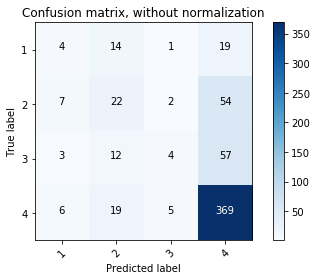

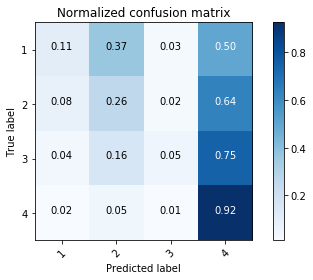

In [99]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, pred_df['prediction'])
class_names=list(unique(y_test))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [62]:
print "F1score:",f1_score(pred_df['prediction'],y_test, average = 'macro')

F1score: 0.335035022556496


In [110]:
pd.Series(y_test).value_counts()

4    399
2     85
3     76
1     38
dtype: int64

In [111]:
pd.Series(pred_df['prediction']).value_counts()

4    499
2     67
1     20
3     12
Name: prediction, dtype: int64

The best accuracy we could achieve in multi-class claissification (i.e. across all 4 classes) was just 65% while when we performed binary classification(vulnerable vs non-vulnerable), we noticed 78% accuracy. Our model fails to perform well for the minority classes. Let replace the dataset by well balanced dataset which is obtained by upsampling. (There are also other methods like down sampling, SMOTE etc.) Let's implement and see how it effects the models' performance in the next version of the code.